# Face Feature Analysis (FFA)
Facial Geometric Indicator Calculation(FGI)

In [1]:
import json
import glob
import os
import pandas as pd
import numpy as np
from scipy import stats
from facial_geometric_indicators import FacialGeometricIndicators

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
all_ldmk_data = {}
all_images = {}
NW_id = []
NQ_id = []

for file_path in glob.glob('extracted/updated_landmarks/*.json'):
    file_name = os.path.basename(file_path)
    key = "-".join(file_name.split("-")[:2])
    dyn = file_name.split("-")[3].split("_")
    if "NorthernWei" in dyn or "EasternWei" in dyn or "WesternWei" in dyn:
        NW_id.append(key)
    else:
        NQ_id.append(key)
    
    with open(file_path, 'r') as json_file:
        all_ldmk_data[key] = json.load(json_file)

for file_path in glob.glob('extracted/orthogonalized/*.png'):
    file_name = os.path.basename(file_path)
    key = "-".join(file_name.split("-")[:2])
    all_images[key] = "extracted/orthogonalized/"+file_name

In [3]:
metadata = pd.read_csv('metadata.csv')
metadata.head()

,id,parent_id,category,period,head_body,head,body,head_body_en,TheBuddha(Sidhartha),Bodhisattva,Northern_Wei,Northern_Qi,Sui,Tang,period2,types
0,88,88,佛,北齐,['身'],False,True,-body,True,False,False,True,False,False,Northern_Qi,TheBuddha(Sidhartha)
1,66,66,佛,北齐,"['头', '身']",True,True,-head-body,True,False,False,True,False,False,Northern_Qi,TheBuddha(Sidhartha)
2,90,90,佛,北齐,['身'],False,True,-body,True,False,False,True,False,False,Northern_Qi,TheBuddha(Sidhartha)
3,28,28,菩萨,北魏_东魏,"['头', '身']",True,True,-head-body,False,True,True,False,False,False,Northern_Wei,Bodhisattva
4,190,190,菩萨,北齐,['头'],True,False,-head,False,True,False,True,False,False,Northern_Qi,Bodhisattva


In [4]:
def calculate_values_for_group(group, all_ldmk_data):
    values = []
    for file_name in group:
        landmarks = all_ldmk_data[file_name]
        fgi = FacialGeometricIndicators(landmarks)
        fgi.calculate_all()
        fgi.calculate_fsa()
        values.append(fgi.get_fgi_values())
    return values

def plot_histograms(values, title):
    plt.figure(figsize=(18, 24))  
    
    keys = list(values[0].keys())
    n_keys = len(keys)
    n_rows = 6
    n_cols = 3

    for i, key in enumerate(keys):
        plt.subplot(n_rows, n_cols, i + 1)
        data = [v[key] for v in values]
        plt.hist(data, bins=10, alpha=0.5)
        plt.title(f'{key} (mean: {np.mean(data):.2f})')

    for j in range(i + 1, n_rows * n_cols):
        plt.subplot(n_rows, n_cols, j + 1).axis('off')

    plt.suptitle(title, size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_histograms2(group1_values, group2_values, title):
    plt.figure(figsize=(18, 24))  
    
    keys = list(group1_values[0].keys())
    n_keys = len(keys)
    n_rows = 6
    n_cols = 3

    for i, key in enumerate(keys):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        data1 = [v[key] for v in group1_values]
        ax.hist(data1, bins=10, alpha=0.5, color='blue', label=f'Group 1 {key} mean: {np.mean(data1):.2f}',density=True)
        data2 = [v[key] for v in group2_values]
        ax.hist(data2, bins=10, alpha=0.5, color='orange', label=f'Group 2 {key} mean: {np.mean(data2):.2f}',density=True)
        ax.set_title(f'{key}')
        ax.legend()

    for j in range(i + 1, n_rows * n_cols):
        plt.subplot(n_rows, n_cols, j + 1).axis('off')

    plt.suptitle(title, size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
values_group_nq = calculate_values_for_group(NQ_id, all_ldmk_data)
values_group_nw= calculate_values_for_group(NW_id, all_ldmk_data)

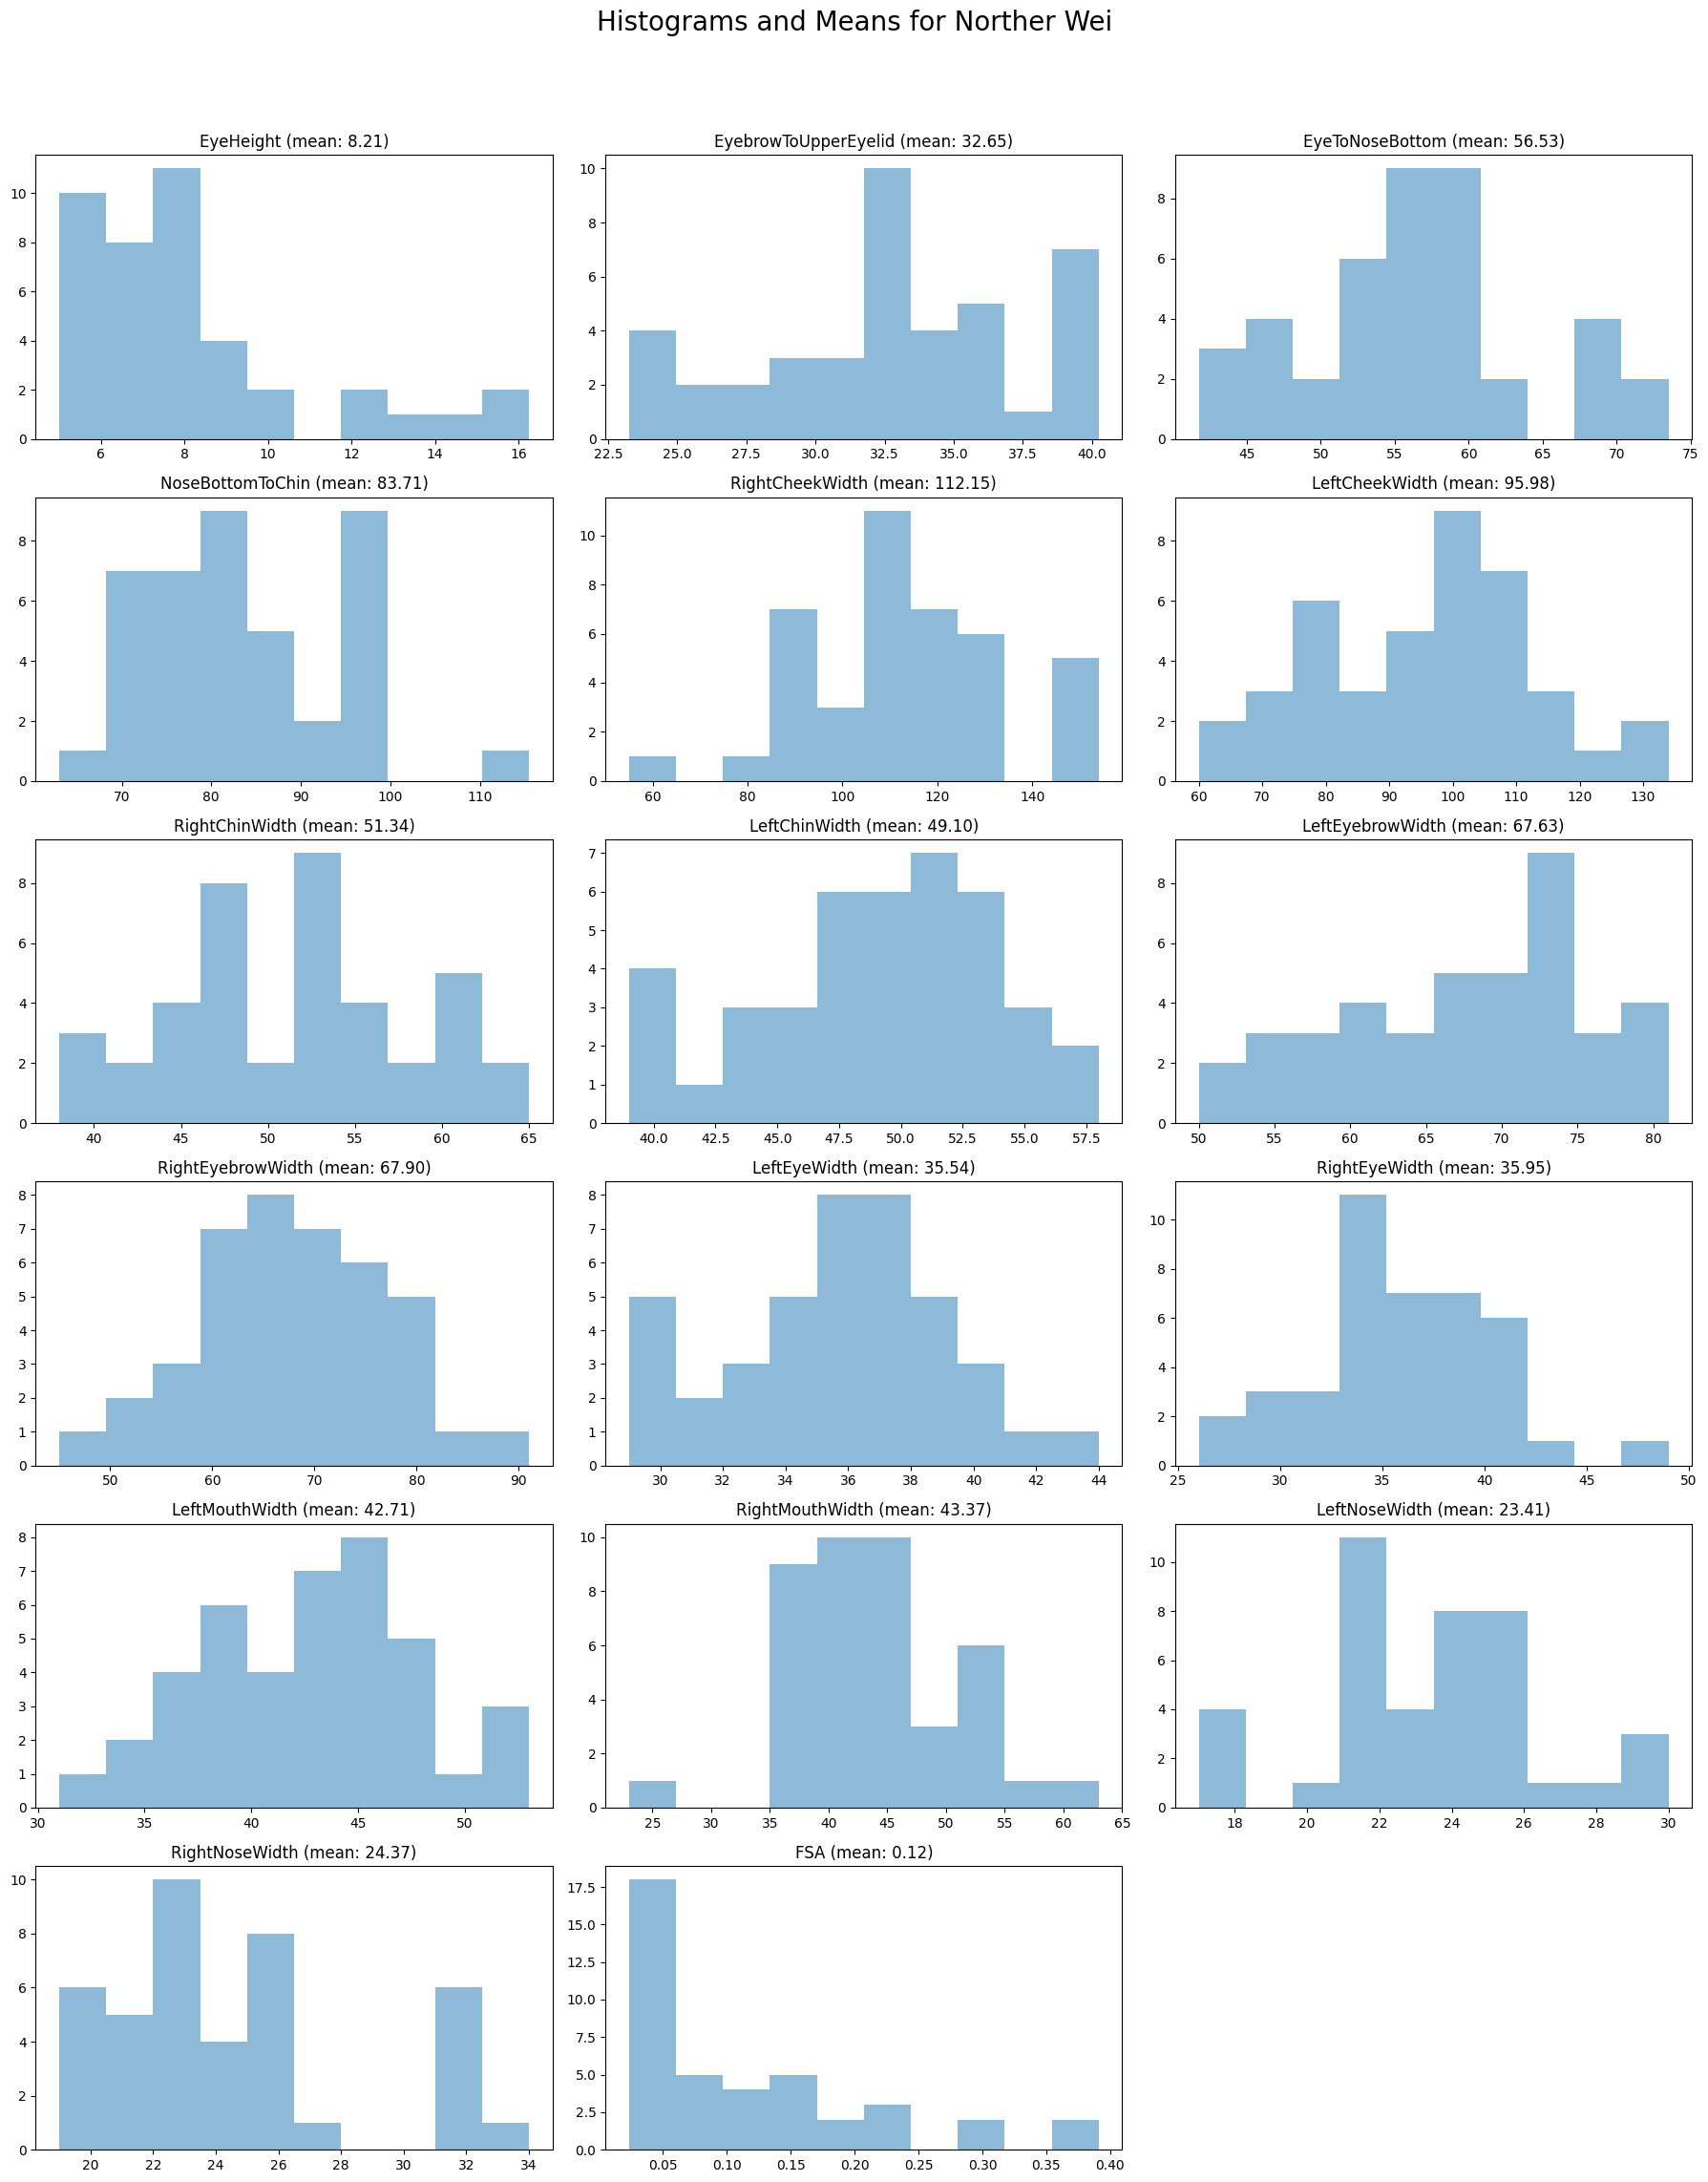

In [6]:
plot_histograms(values_group_nw, 'Histograms and Means for Norther Wei')

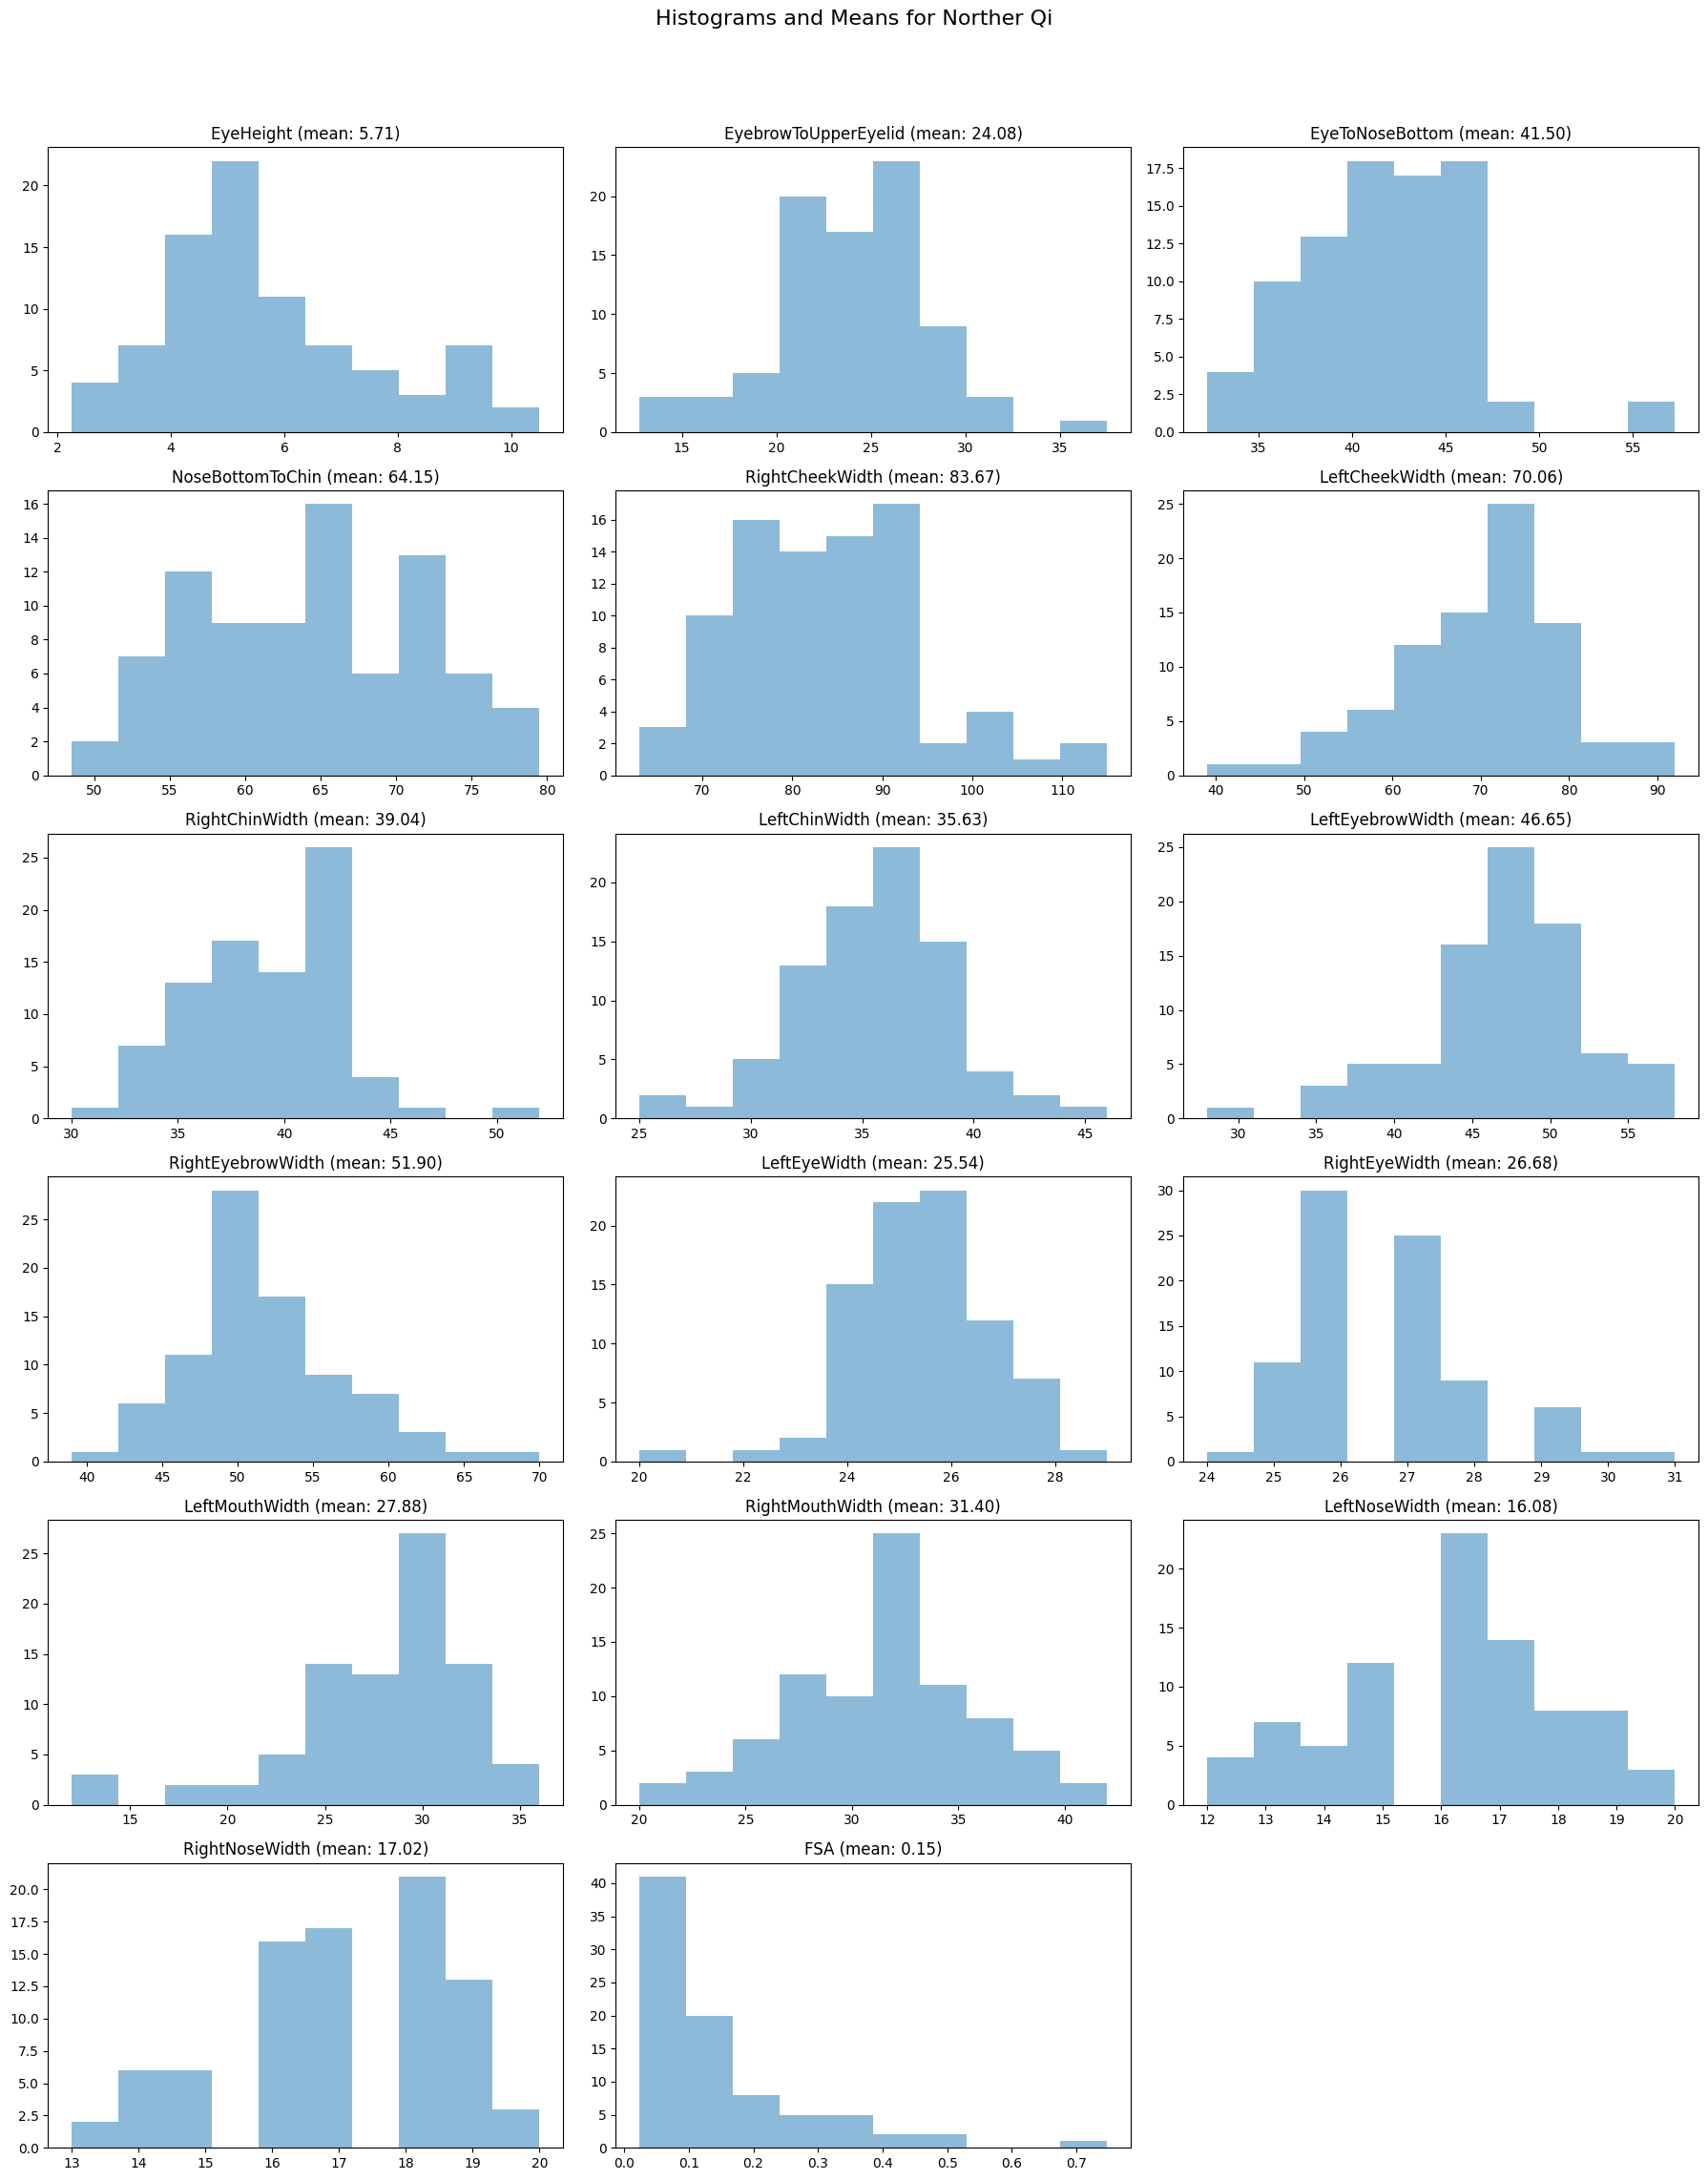

In [42]:
plot_histograms(values_group_nq, 'Histograms and Means for Norther Qi')

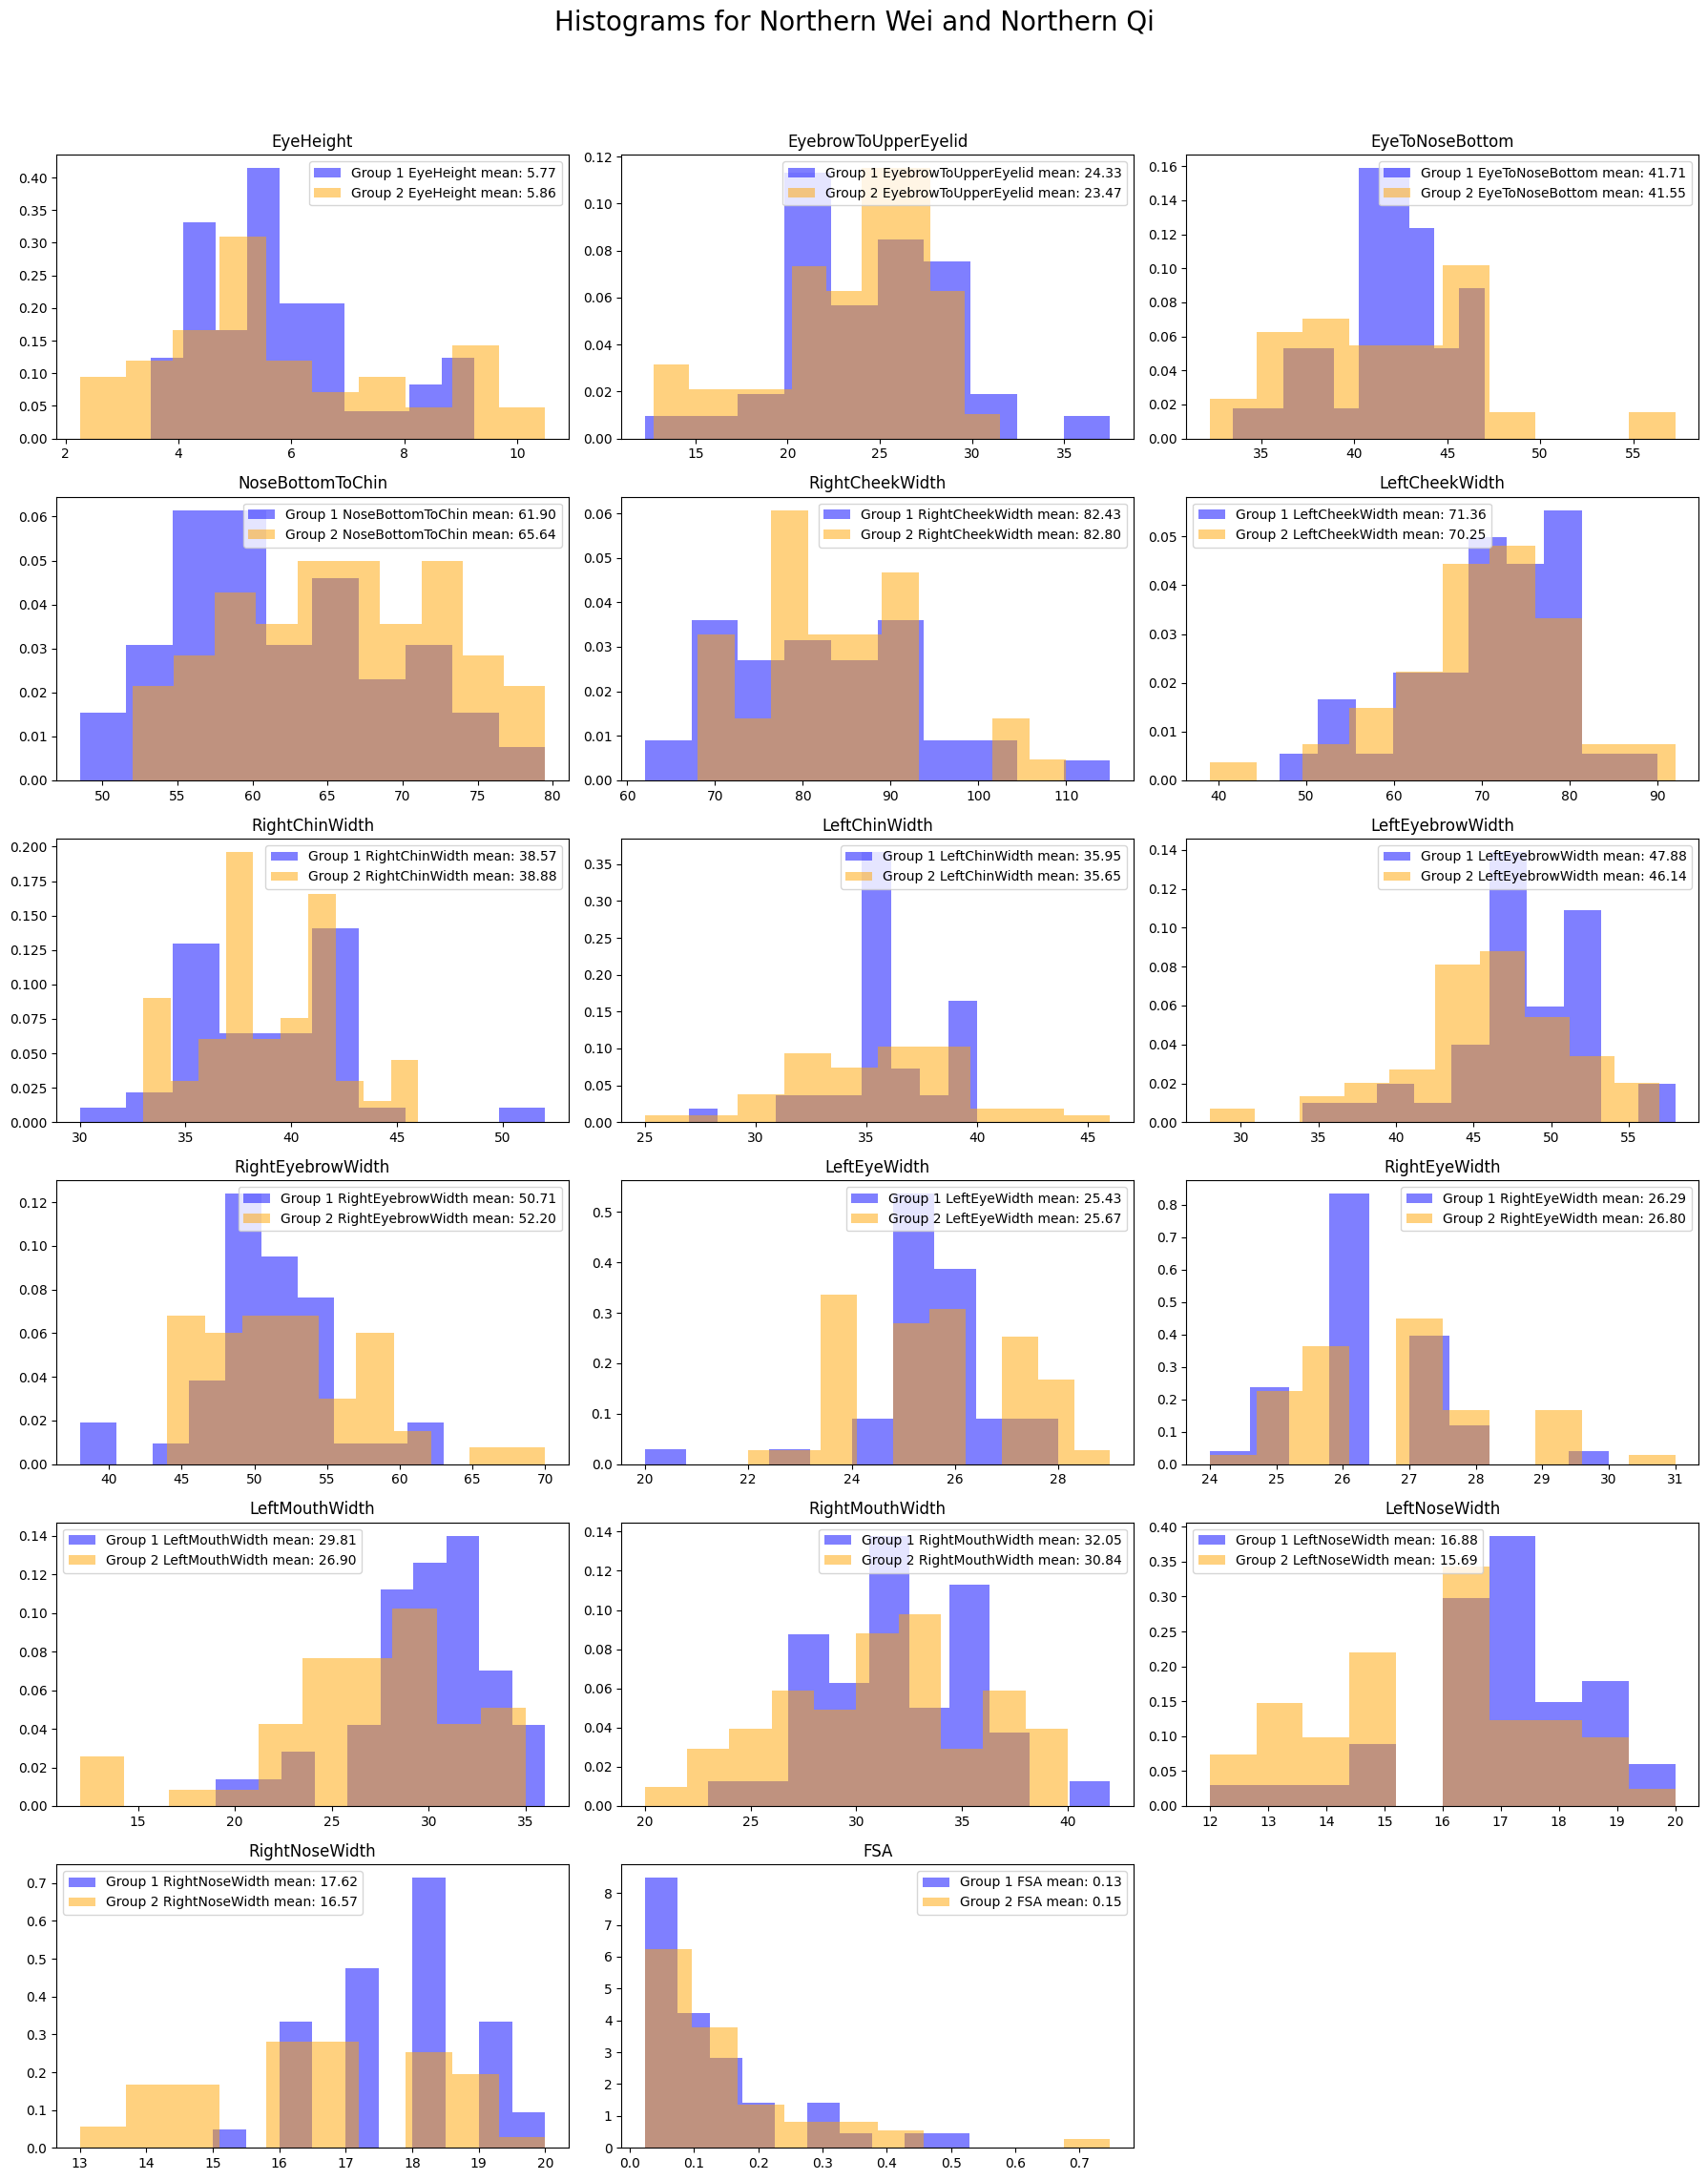

In [55]:
plot_histograms2(values_group_nw, values_group_nq, 'Histograms for Northern Wei and Northern Qi')

In [62]:
def plot_violinplots(group1_values, group2_values, title):
    plt.figure(figsize=(18, 24))  
    
    keys = list(group1_values[0].keys())
    n_keys = len(keys)
    n_rows = 6
    n_cols = 3

    long_data = []
    for i, key in enumerate(keys):
        long_data.extend([{'Group': 'Northern Wei', 'Key': key, 'Value': v[key]} for v in group1_values])
        long_data.extend([{'Group': 'Northern Qi', 'Key': key, 'Value': v[key]} for v in group2_values])
    df_long = pd.DataFrame(long_data)

    for i, key in enumerate(keys):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        sns.violinplot(x='Key', y='Value', hue='Group', split=True, data=df_long[df_long['Key'] == key], inner='stick', palette=['blue', 'orange'])
        ax.set_title(f'{key}')
        if i % n_cols == 0:
            ax.legend(title='Group')
        else:
            ax.legend([],[], frameon=False)

    for j in range(i + 1, n_rows * n_cols):
        plt.subplot(n_rows, n_cols, j + 1).axis('off')

    plt.suptitle(title, size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

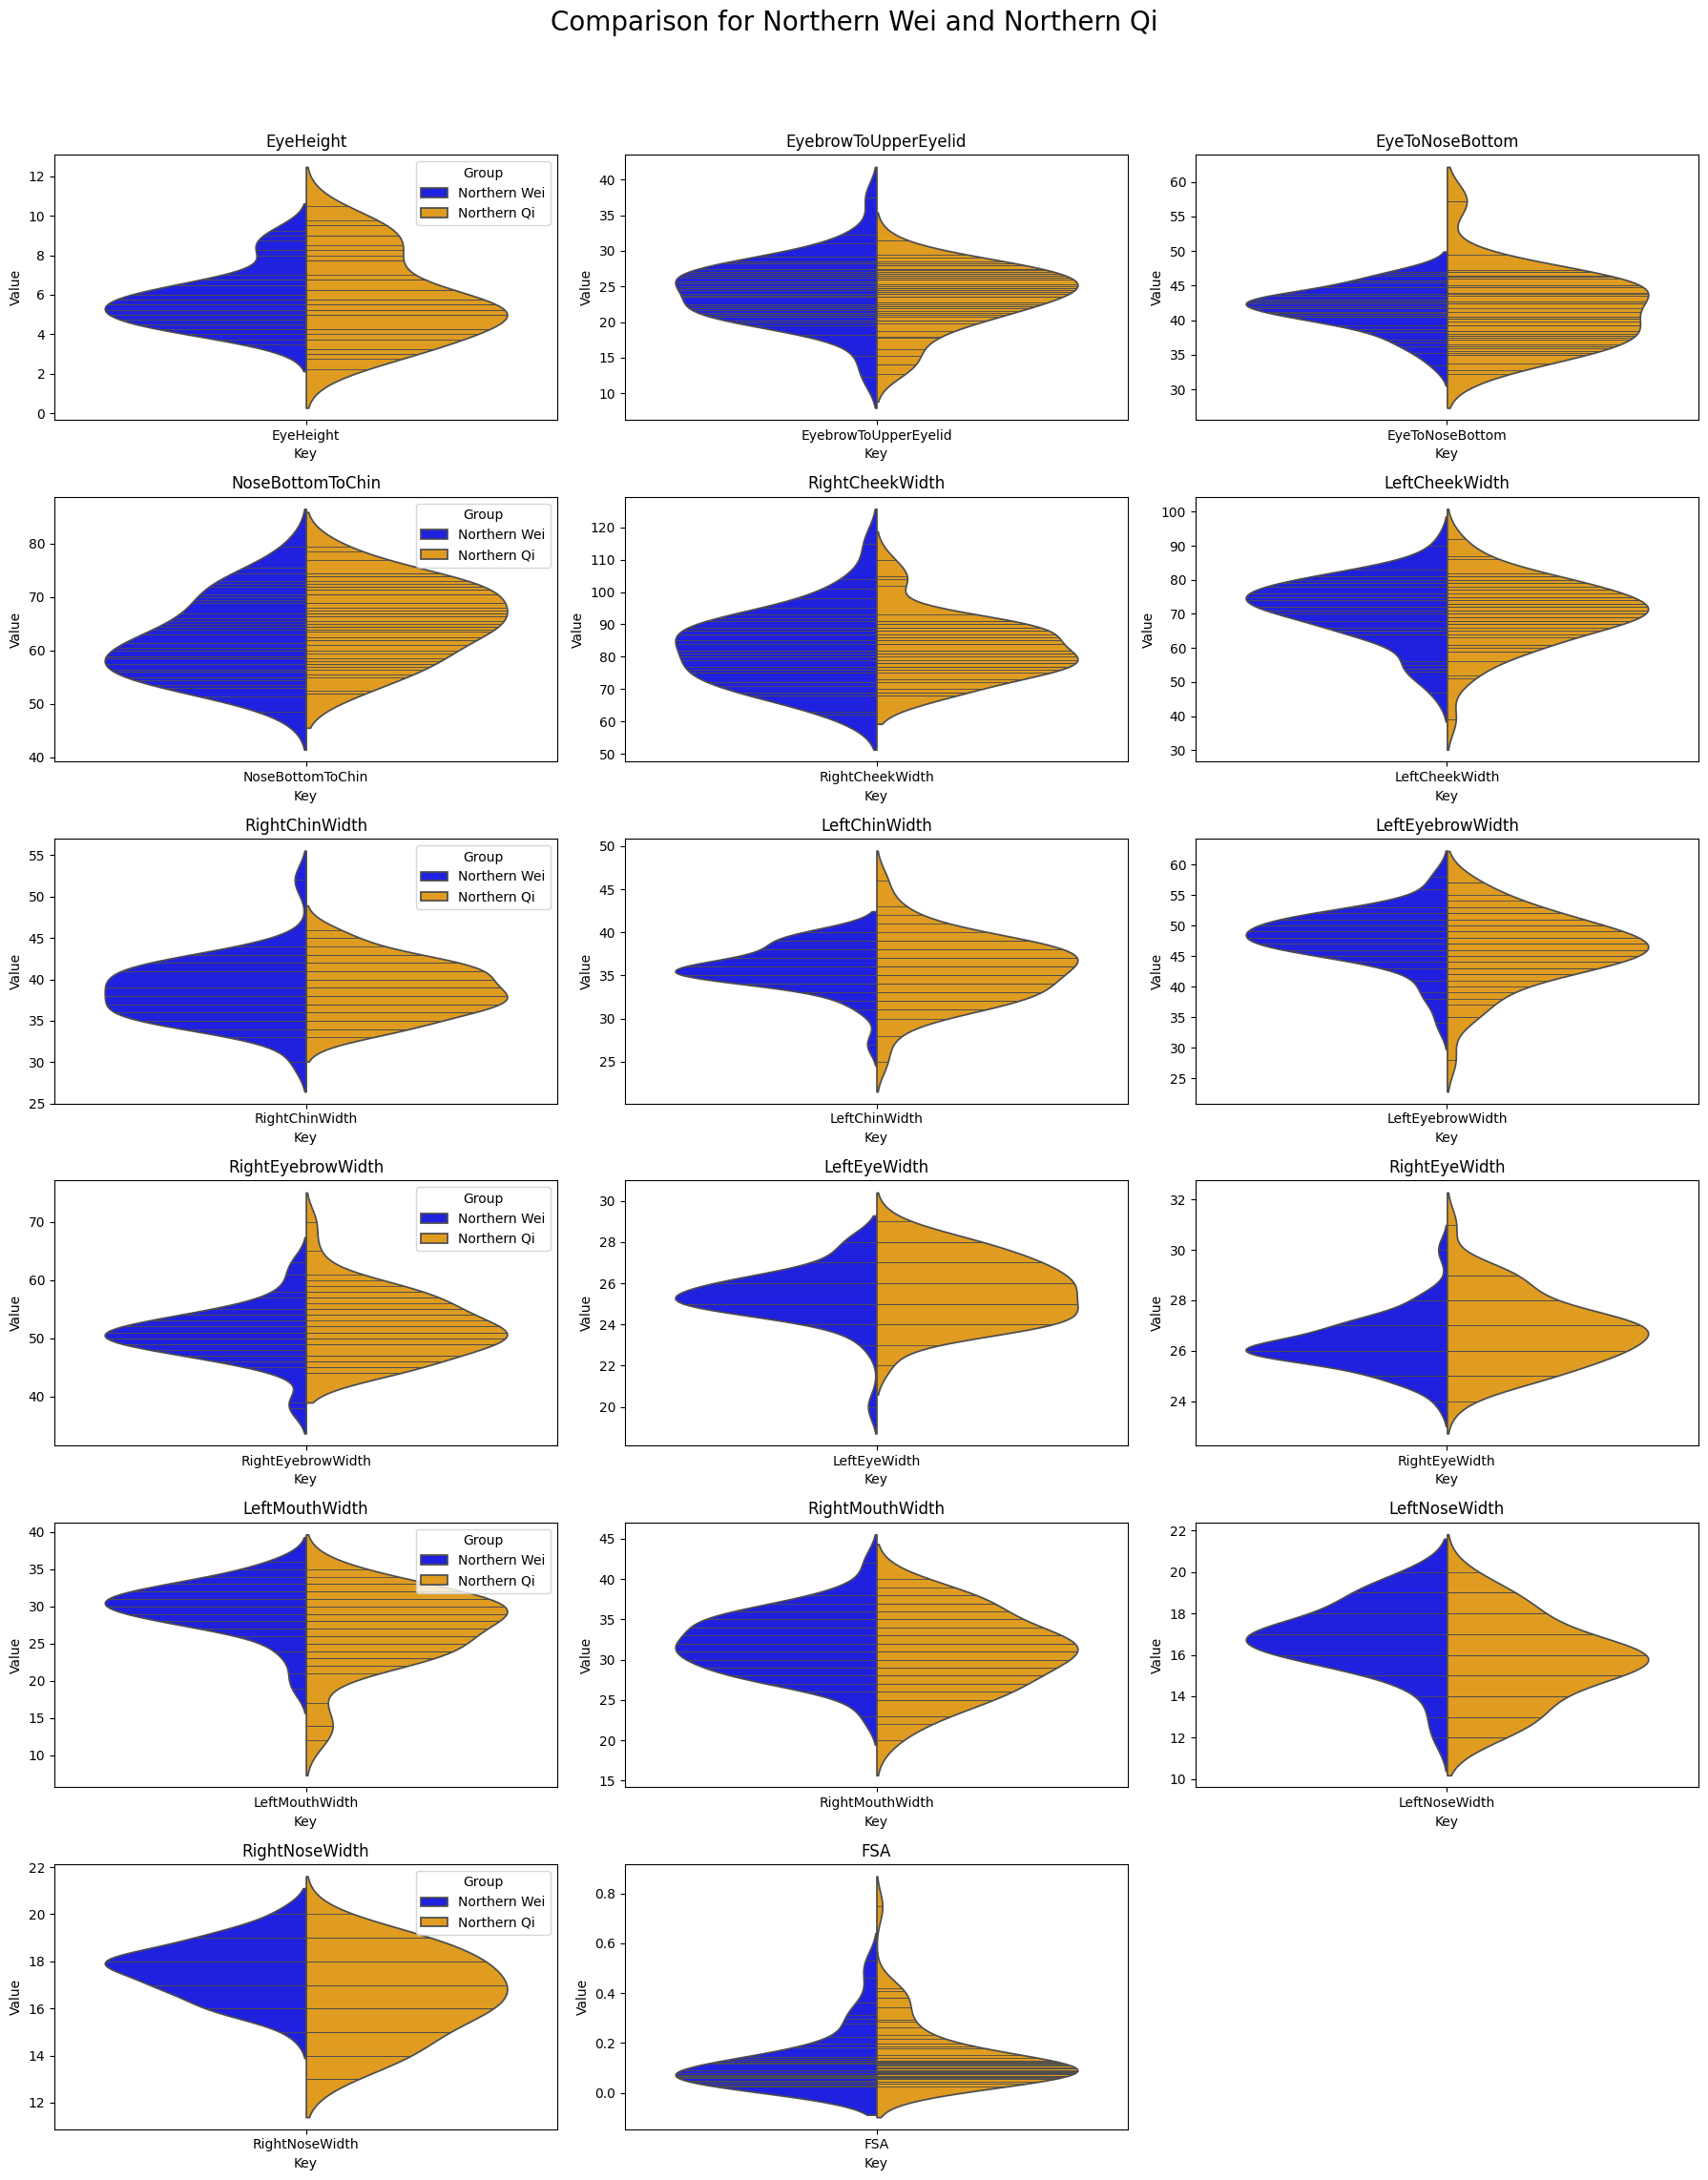

In [64]:
plot_violinplots(values_group_nw, values_group_nq, 'Comparison for Northern Wei and Northern Qi')

In [88]:
def mean_confidence_interval(data, confidence=0.95):

    mean = np.mean(data)
    n = len(data)
    sem = stats.sem(data) 
    margin = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    
    return mean, mean - margin, mean + margin

def plot_pointplots(group1_values, group2_values, title):
    plt.figure(figsize=(18, 24))
    
    keys = list(group1_values[0].keys())
    n_rows = 6
    n_cols = 3

    for i, key in enumerate(keys):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        
        group1_data = [v[key] for v in group1_values]
        group2_data = [v[key] for v in group2_values]
        
        mean1, ci_lower1, ci_upper1 = mean_confidence_interval(group1_data)
        mean2, ci_lower2, ci_upper2 = mean_confidence_interval(group2_data)
        
        data = pd.DataFrame({
            'Group': ['Northern Wei', 'Norther Qi'],
            'Mean': [mean1, mean2],
            'CI Lower': [ci_lower1, ci_lower2],
            'CI Upper': [ci_upper1, ci_upper2]
        })
        
        
        sns.pointplot(x='Group', y='Mean', data=data, ax=ax, 
                      capsize=0.1, linewidth=1, #join = True, #linestyle='none', 
                      markers='o')
        
        for j in range(len(data)):
            ax.errorbar(x=j, y=data.loc[j, 'Mean'], 
                        yerr=[[data.loc[j, 'Mean'] - data.loc[j, 'CI Lower']], 
                              [data.loc[j, 'CI Upper'] - data.loc[j, 'Mean']]],
                        fmt='none', capsize=5, elinewidth=2, color='grey')
        
        ax.set_title(key)
        ax.set_ylabel('Value')

    for j in range(i + 1, n_rows * n_cols):
        plt.subplot(n_rows, n_cols, j + 1).axis('off')

    plt.suptitle(title, size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



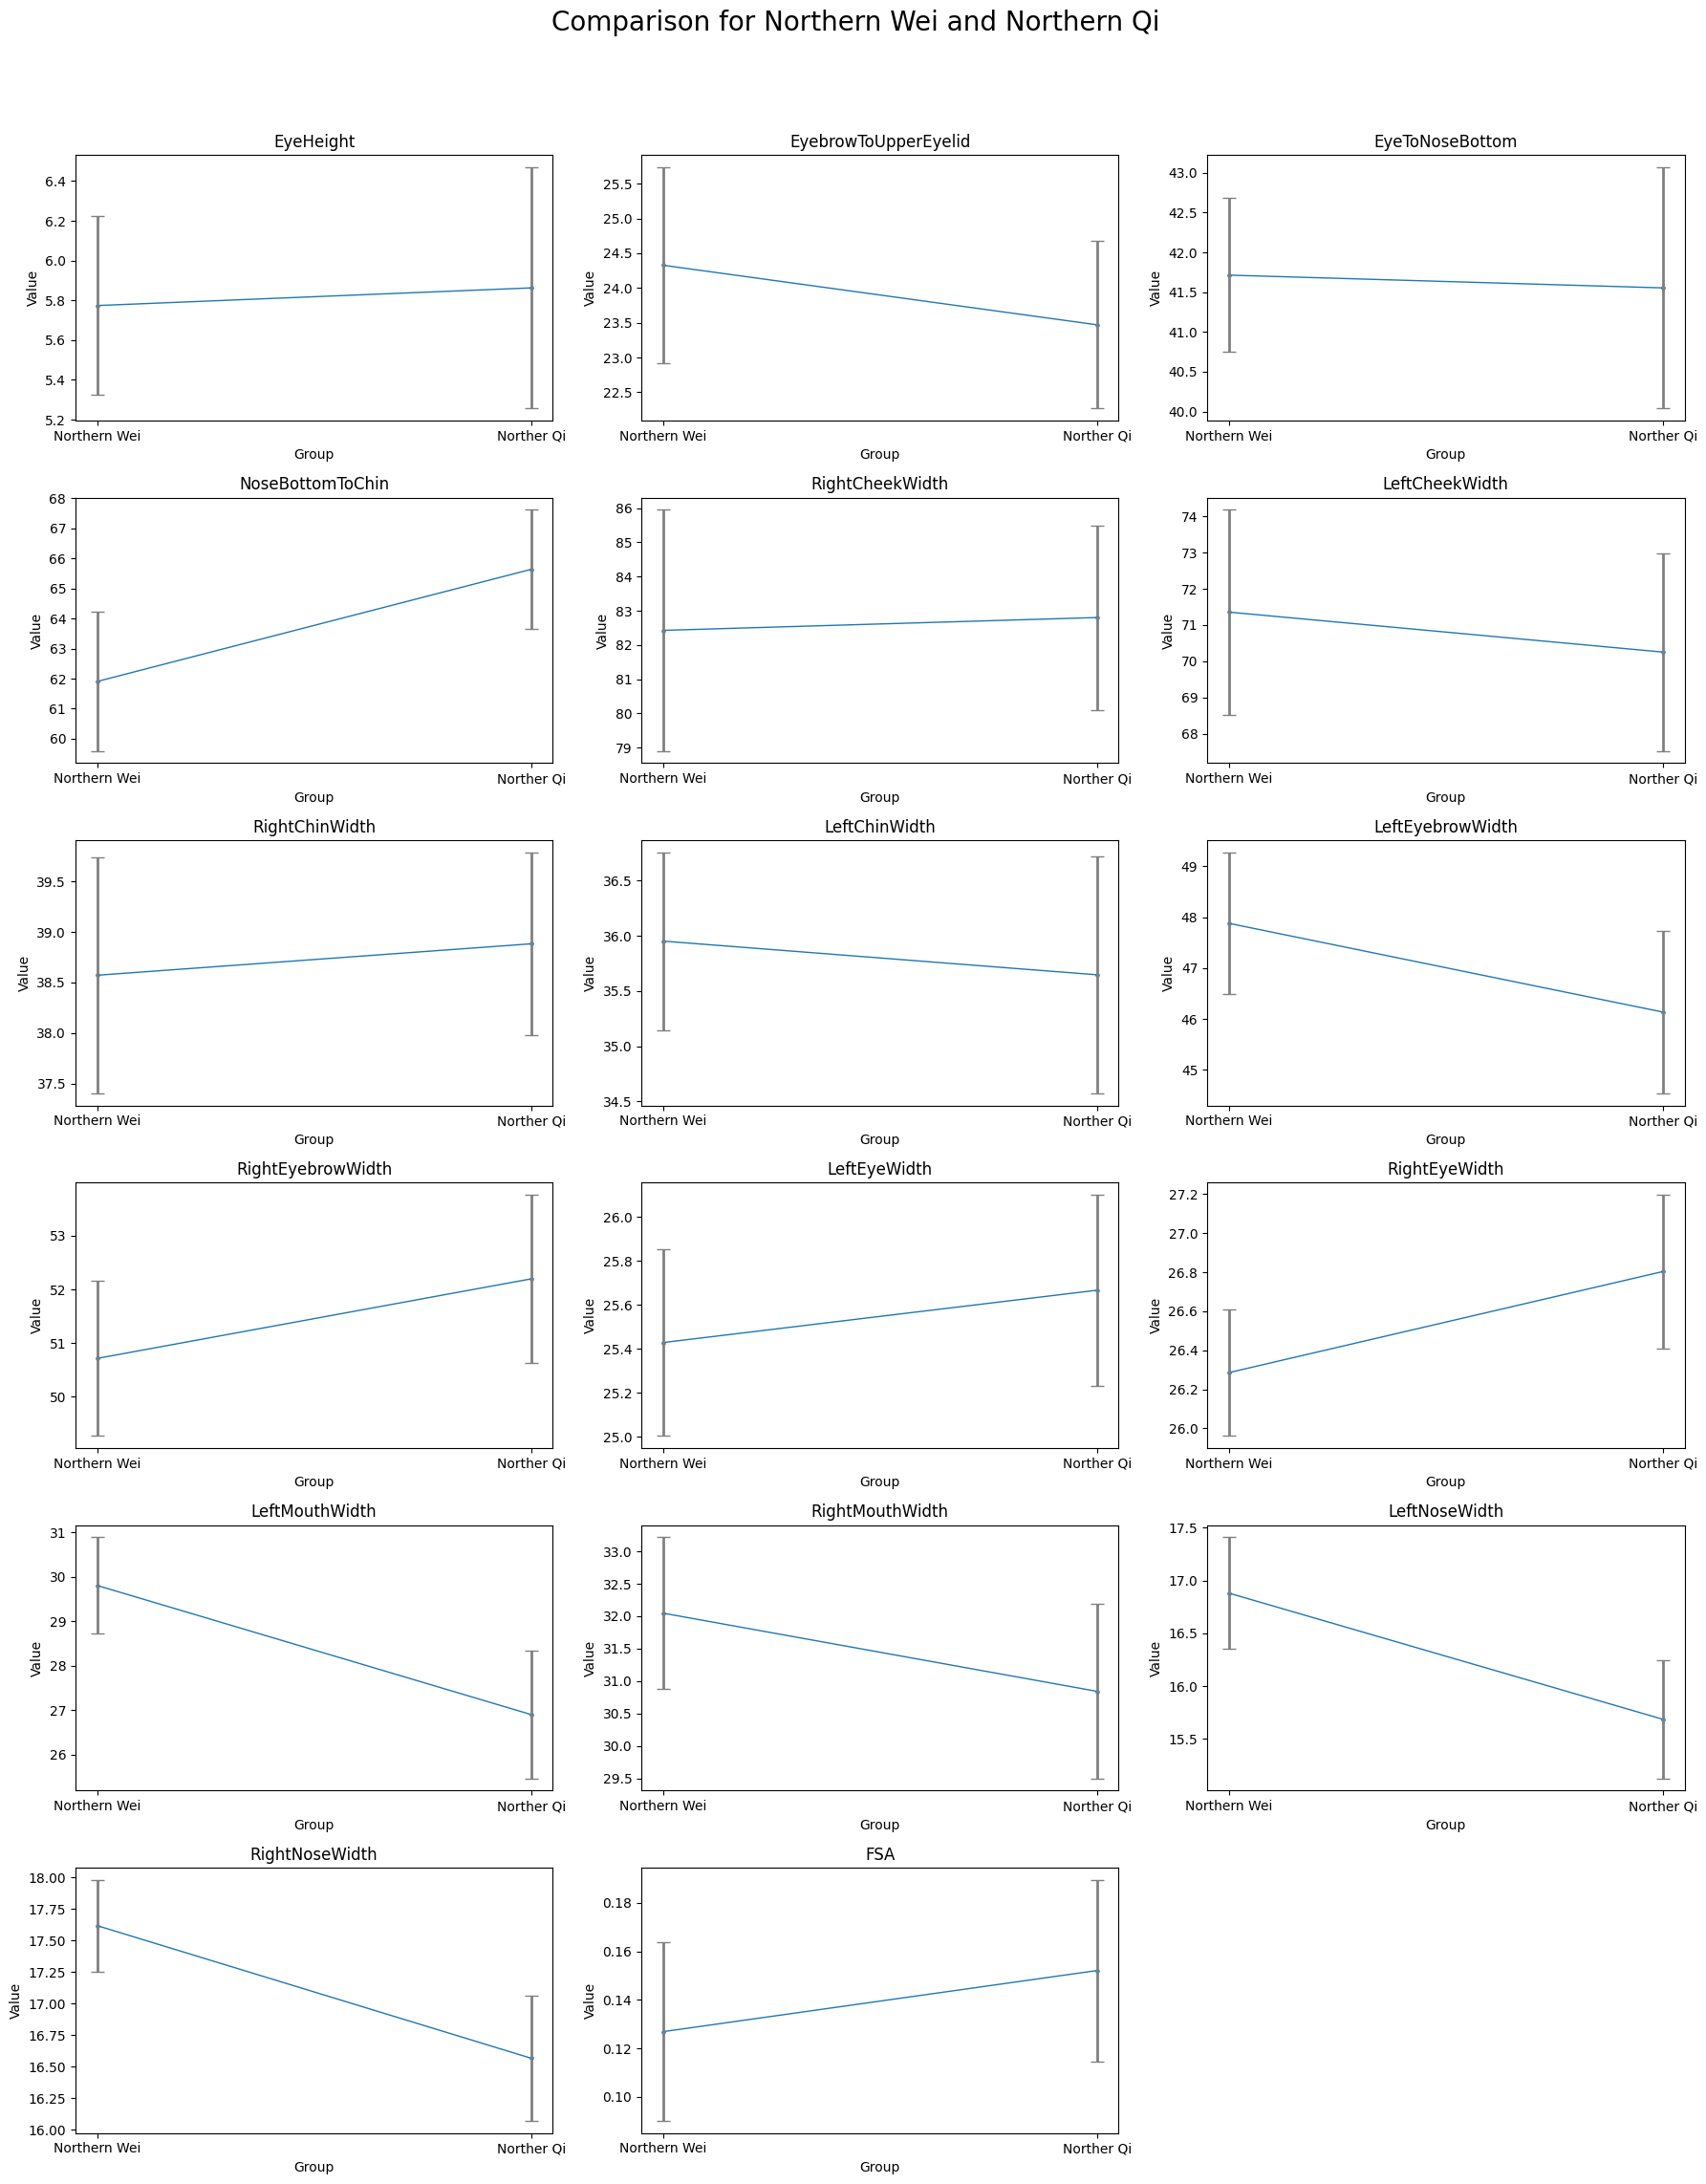

In [89]:
plot_pointplots(values_group_nw, values_group_nq, 'Comparison for Northern Wei and Northern Qi')

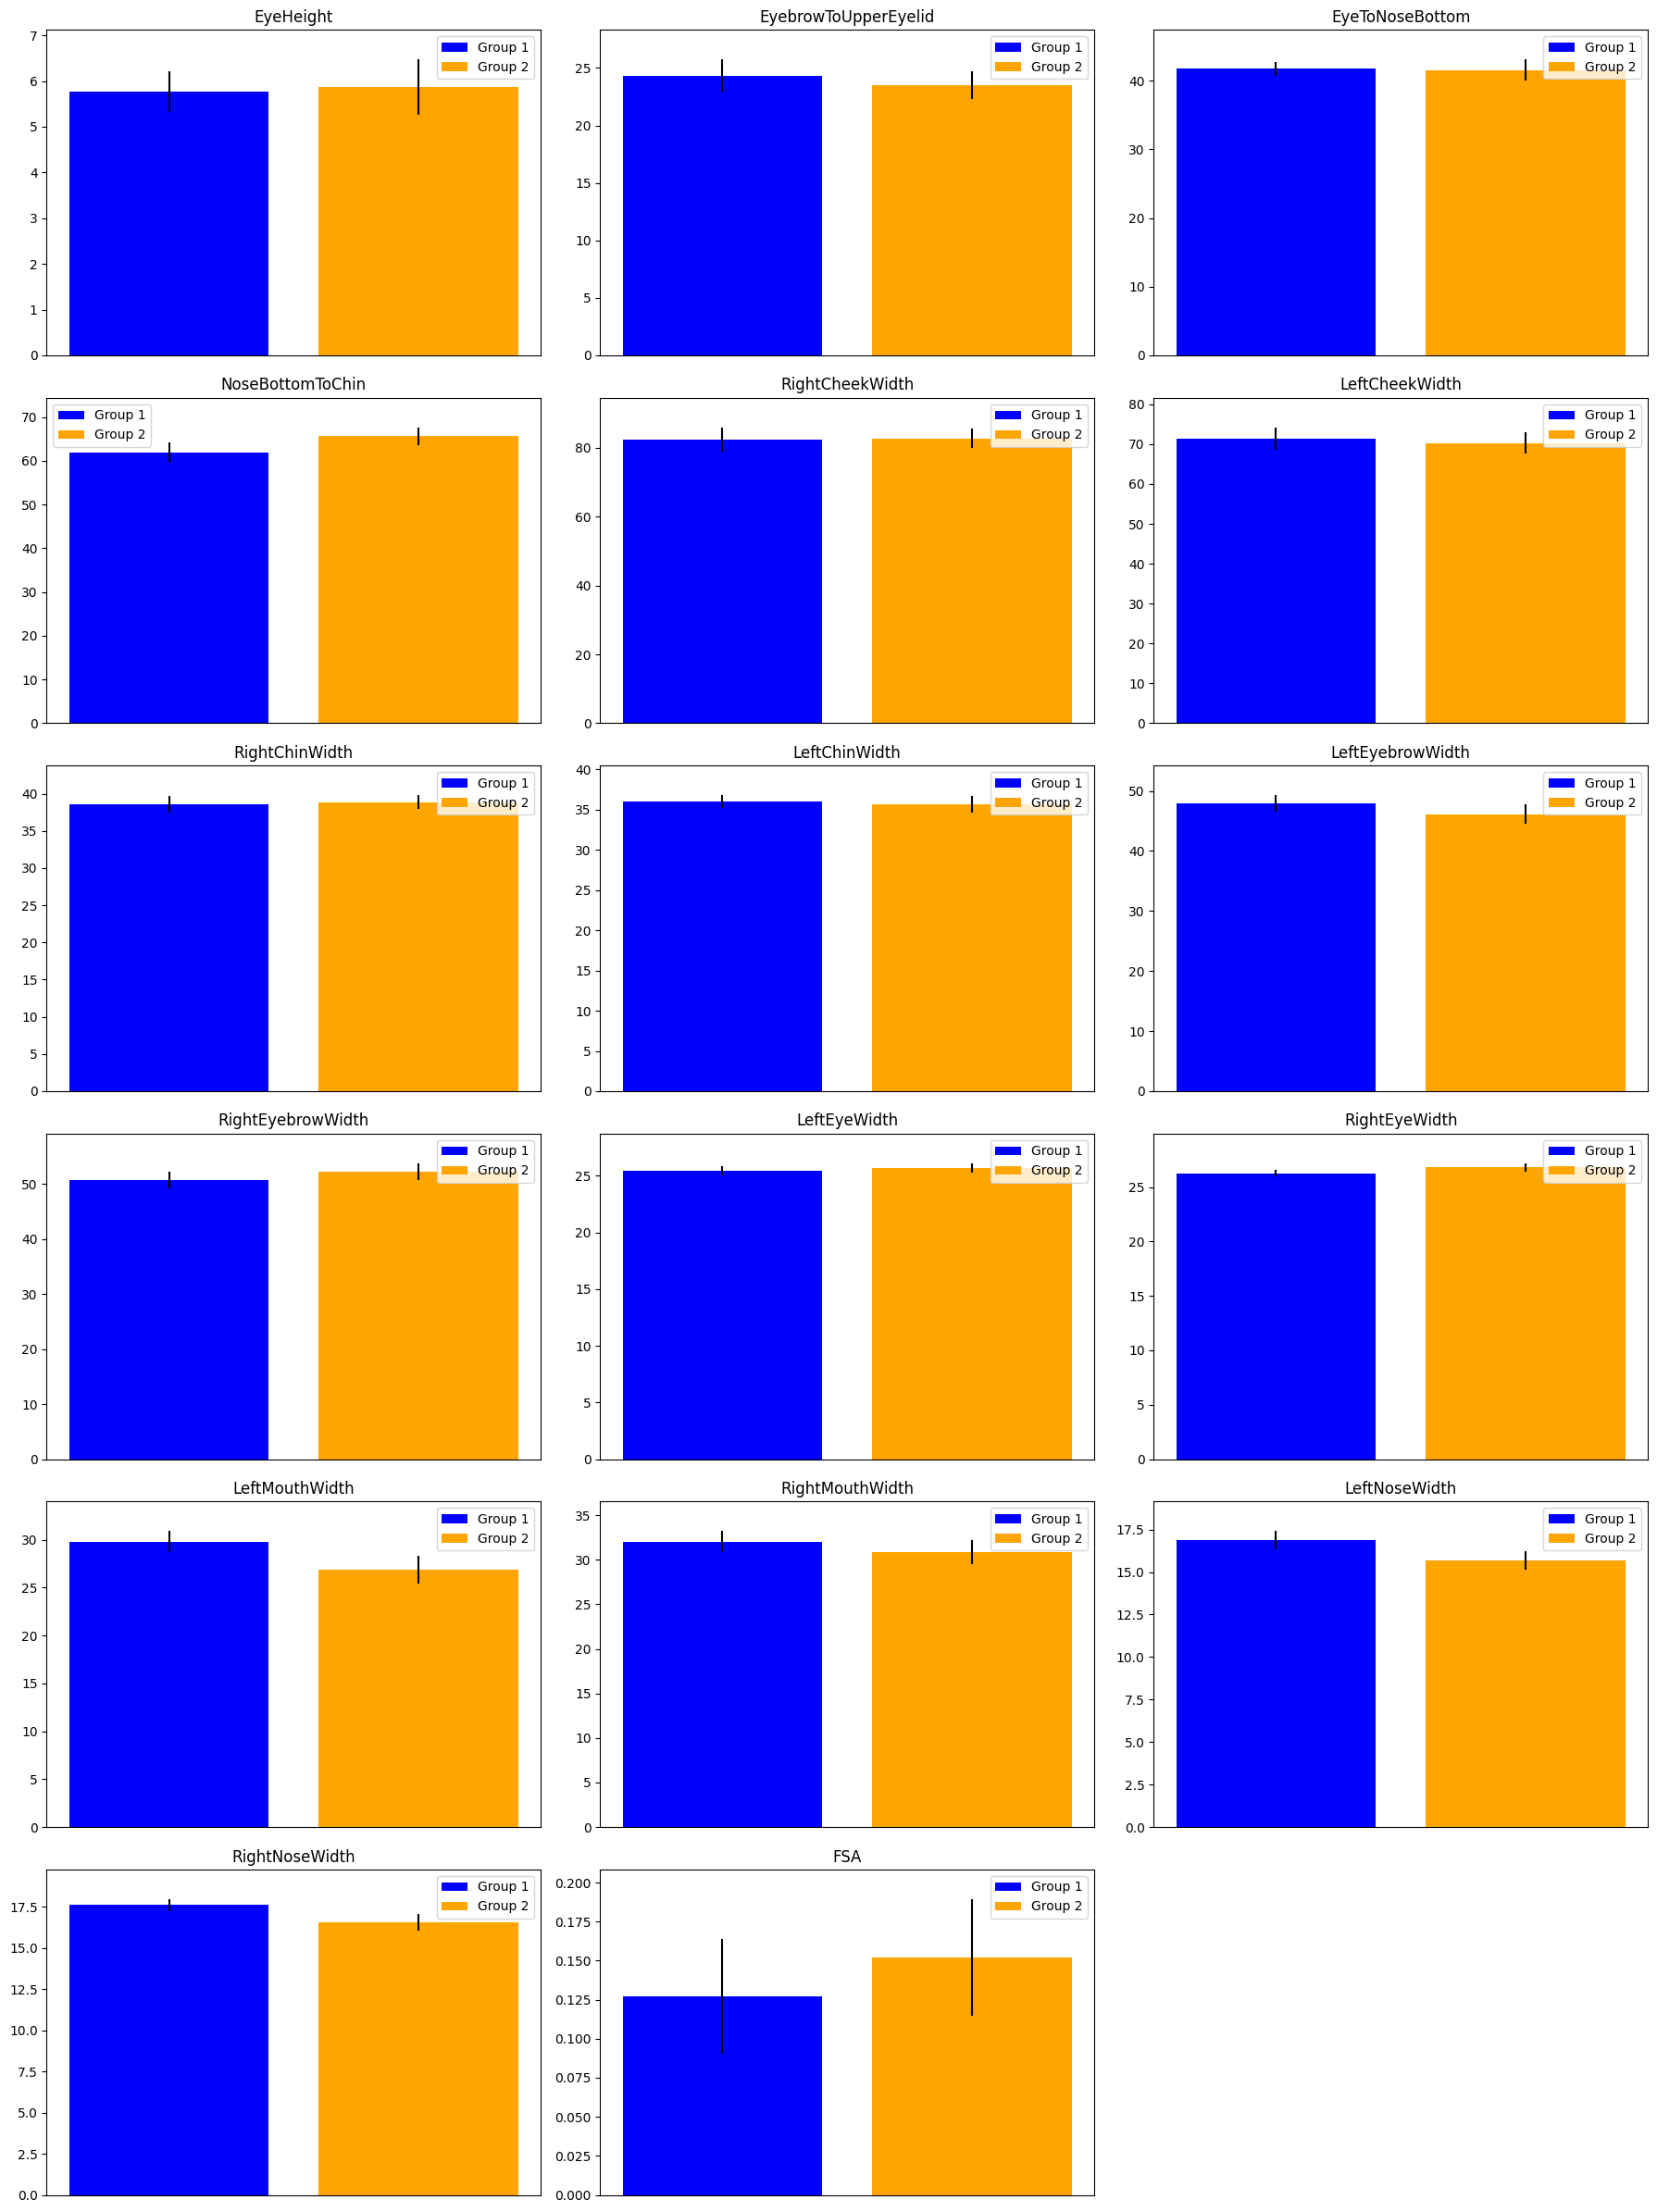

In [58]:
keys = values_group_nw[0].keys()  # 获取FGI值的键
results = {key: {'Group 1': {}, 'Group 2': {}} for key in keys}

# 计算每个FGI值的均值和95%置信区间
for key in keys:
    data_group1 = [v[key] for v in values_group_nw]
    data_group2 = [v[key] for v in values_group_nq]
    
    mean1, lower1, upper1 = mean_confidence_interval(data_group1)
    mean2, lower2, upper2 = mean_confidence_interval(data_group2)
    
    results[key]['Group 1']['Mean'] = mean1
    results[key]['Group 1']['CI'] = (lower1, upper1)
    results[key]['Group 2']['Mean'] = mean2
    results[key]['Group 2']['CI'] = (lower2, upper2)

n_rows = 6
n_cols = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 24))

for i, (key, result) in enumerate(results.items()):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    
    ax.bar(0, result['Group 1']['Mean'], color='blue', label='Group 1', yerr=[[result['Group 1']['Mean'] - result['Group 1']['CI'][0]], [result['Group 1']['CI'][1] - result['Group 1']['Mean']]])
    ax.bar(1, result['Group 2']['Mean'], color='orange', label='Group 2', yerr=[[result['Group 2']['Mean'] - result['Group 2']['CI'][0]], [result['Group 2']['CI'][1] - result['Group 2']['Mean']]])
    
    ax.set_title(key)
    ax.set_ylim([0, max(result['Group 1']['CI'][1], result['Group 2']['CI'][1]) * 1.1])  
    ax.set_xticks([])
    ax.legend()

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()